# Product Review Sentiment Analysis
This Product Review Sentiment Analysis project is a tool for analyzing customer feedback using Natural Language Processing and Machine Learning. It allows users to upload CSV files of product reviews, preprocesses and cleans the text, and performs both basic and advanced sentiment analysis.

The project visualizes sentiment distributions, generates keyword insights, and creates interactive word clouds, providing valuable business insights into customer satisfaction. Developed in Python on Google Colab, it utilizes industry-standard libraries like NLTK, TextBlob, Hugging Face Transformers, and Scikit-learn for an in-depth analysis and professional presentation of results.

## 1. Setup: Import Libraries and Install Dependencies

In [1]:
# Install necessary libraries
!pip install pandas nltk textblob matplotlib seaborn plotly wordcloud transformers rake-nltk scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import nltk
from textblob import TextBlob
from transformers import pipeline
from rake_nltk import Rake
import re
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 2. File Upload

In [2]:
# Upload CSV file
from google.colab import files
uploaded = files.upload()

# Load the CSV into a DataFrame
import io
df = pd.read_csv(io.BytesIO(uploaded[next(iter(uploaded))]))

# Display the first few rows of the dataset
df.head()

Saving product_reviews.csv to product_reviews.csv


,review
0,I absolutely love this product! It has changed...
1,This is the worst purchase I've ever made. Tot...
2,"The quality is okay, but I expected more for t..."
3,"Fantastic! I use it every day, and it works pe..."
4,Not worth the money. I wouldn't buy this again.


## 3. Data Validation and Initial Exploration

In [3]:
# Check for missing values and data types
print("Missing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)

# Drop rows with missing reviews
df.dropna(subset=['review'], inplace=True)

# Display basic dataset information
df.info()

Missing Values:
 review    0
dtype: int64

Data Types:
 review    object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  21 non-null     object
dtypes: object(1)
memory usage: 296.0+ bytes


## 4. Clean and Preprocess Text Data

In [4]:
# Basic data cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    return text

# Apply cleaning to the 'review' column
df['cleaned_review'] = df['review'].apply(clean_text)

## 5. Exploratory Data Analysis (EDA)
### a. Review Length Distribution

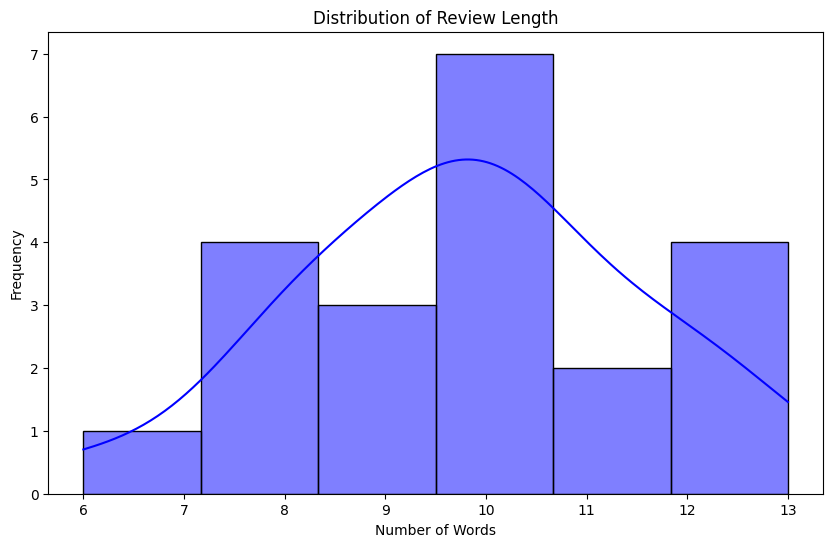

In [5]:
# Add a column for review length
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))

# Plot review length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], kde=True, color='blue')
plt.title('Distribution of Review Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

### b. Common Words Analysis

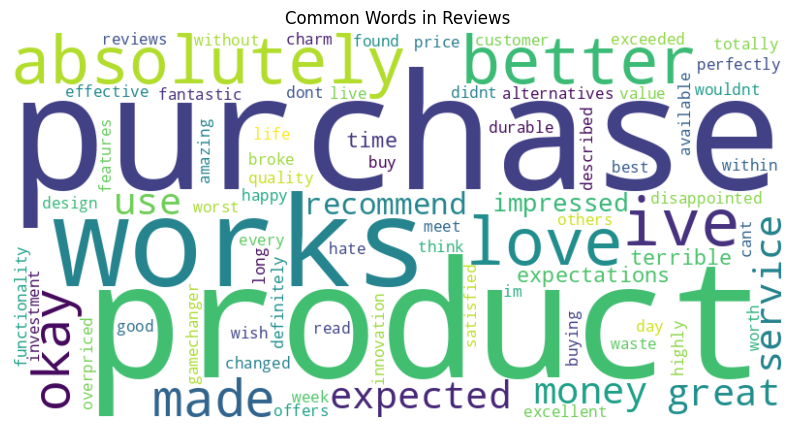

In [6]:
# Generate common words word cloud
all_words = ' '.join(df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Reviews")
plt.show()

## 6. Basic Sentiment Analysis with TextBlob

In [7]:
# TextBlob sentiment analysis
df['textblob_polarity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Map polarity to sentiment labels
df['textblob_sentiment'] = df['textblob_polarity'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')
df[['review', 'textblob_polarity', 'textblob_sentiment']].head()

,review,textblob_polarity,textblob_sentiment
0,I absolutely love this product! It has changed...,0.500,Positive
1,This is the worst purchase I've ever made. Tot...,-0.875,Negative
2,"The quality is okay, but I expected more for t...",0.300,Positive
3,"Fantastic! I use it every day, and it works pe...",0.700,Positive
4,Not worth the money. I wouldn't buy this again.,-0.150,Negative


## 7. Transformer-based Sentiment Analysis

In [8]:
# Transformer-based sentiment analysis using DistilBERT
sentiment_pipeline = pipeline("sentiment-analysis")
df['transformer_sentiment'] = df['cleaned_review'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

# Display updated dataset with sentiments
df[['review', 'textblob_sentiment', 'transformer_sentiment']].head()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

,review,textblob_sentiment,transformer_sentiment
0,I absolutely love this product! It has changed...,Positive,POSITIVE
1,This is the worst purchase I've ever made. Tot...,Negative,NEGATIVE
2,"The quality is okay, but I expected more for t...",Positive,POSITIVE
3,"Fantastic! I use it every day, and it works pe...",Positive,POSITIVE
4,Not worth the money. I wouldn't buy this again.,Negative,NEGATIVE


## 8. Visualize Sentiment Distribution

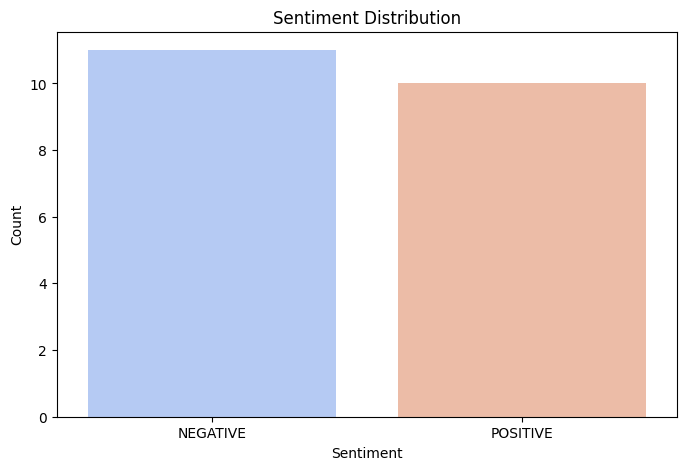

In [9]:
# Count and visualize sentiments
sentiment_counts = df['transformer_sentiment'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## 9. Extract Keywords with RAKE

In [10]:
# Initialize RAKE for keyword extraction
rake_nltk_var = Rake()

# Define keyword extraction function
def extract_keywords(text):
    rake_nltk_var.extract_keywords_from_text(text)
    return rake_nltk_var.get_ranked_phrases()

# Apply the function and store keywords
df['keywords'] = df['cleaned_review'].apply(extract_keywords)
df[['review', 'keywords']].head()

,review,keywords
0,I absolutely love this product! It has changed...,"[absolutely love, product, life, changed, better]"
1,This is the worst purchase I've ever made. Tot...,[worst purchase ive ever made totally disappoi...
2,"The quality is okay, but I expected more for t...","[quality, price, okay, expected]"
3,"Fantastic! I use it every day, and it works pe...","[works perfectly, every day, use, fantastic]"
4,Not worth the money. I wouldn't buy this again.,"[wouldnt buy, worth, money]"


## 10. Interactive Keyword Word Cloud

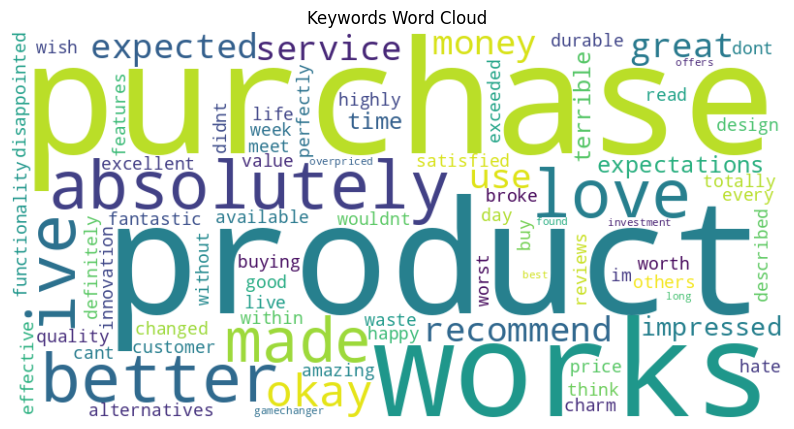

In [11]:
# Concatenate keywords and generate word cloud
all_keywords = ' '.join([' '.join(keywords) for keywords in df['keywords']])

# Display keyword word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Keywords Word Cloud")
plt.show()

## 11. Convert Sentiments to Numerical Labels

In [12]:
# Convert sentiments to numerical labels for model training
df['sentiment_label'] = df['transformer_sentiment'].map({'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2})

## 12. Vectorize Text Data for Model Training

In [13]:
# Use TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_review']).toarray()
y = df['sentiment_label']

## 13. Split Data for Training and Testing

In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 14. Model Training (Random Forest)

In [15]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 15. Model Training (SVM)

In [16]:
# Train Support Vector Classifier
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

## 16. Model Evaluation

In [17]:
# Predict with Random Forest
rf_pred = rf_model.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_pred))

# Predict with SVM
svm_pred = svm_model.predict(X_test)
print("SVM Classification Report:\n", classification_report(y_test, svm_pred))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           2       0.33      0.50      0.40         2

    accuracy                           0.40         5
   macro avg       0.42      0.42      0.40         5
weighted avg       0.43      0.40      0.40         5

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           2       0.00      0.00      0.00         2

    accuracy                           0.20         5
   macro avg       0.17      0.17      0.17         5
weighted avg       0.20      0.20      0.20         5



## 17. Confusion Matrix Visualization

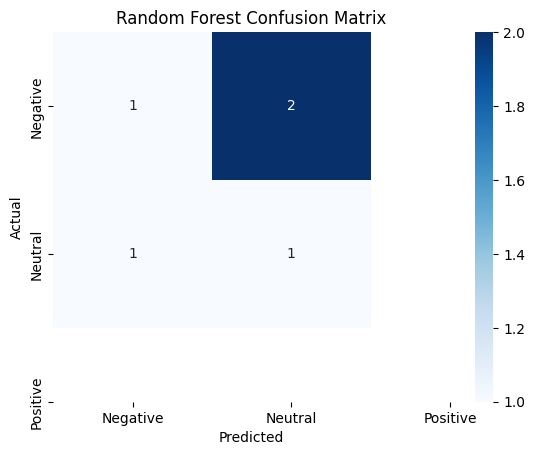

In [18]:
# Plot confusion matrix for Random Forest
conf_matrix = confusion_matrix(y_test, rf_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 18. Save and Download Processed Data

In [19]:
# Save final DataFrame to CSV
df.to_csv('sentiment_analysis_results.csv', index=False)

# Provide download link
from google.colab import files
files.download('sentiment_analysis_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 19. Hyperparameter Tuning (Grid Search for SVM)

In [20]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['linear', 'rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

# Display best parameters
print("Best parameters:", grid.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, k

## 20. Conclusion
This project provides an in-depth analysis pipeline, from data upload and validation to advanced model training and evaluation.